In [8]:
#imports


from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math as m
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline

#function to read from fits file
def readdata(s):

  
  with fits.open(s) as hdul:
    mydata = np.array(hdul[1].data)
    sz = mydata.size
    data1 = np.zeros(sz)
    data2 = np.zeros(sz)
    data3 = np.zeros(sz)
    for i in range(sz):
        data1[i] = mydata[i][0]
        data2[i] = mydata[i][1]
        data3[i] = mydata[i][1]
    return data1,data2,data3



#function for binning
def resolution(r, arr):
    arr2 = np.zeros(len(arr)//r)
    for i in range(len(arr)//r):
        sum = 0
        for j in range(r):
            sum += arr[r*i + j]
        sum/= r
        arr2[i] = sum
    return arr2

#smoothening
def smoothen(arr):
    smoothed_signal = convolve(arr, Box1DKernel(5))
    return smoothed_signal

'''
    for i in range(2, len(arr)-3):
        arr[i] = (arr[i-2] + arr[i-1] + arr[i] + arr[i+1] + arr[i+2])/5
    return arr
'''

def process_marks(marks_list, peak_times): #takes the list of flares with redundancies and removes them. 
    #Finds accurate start and end times based on increasing decreasing logic
    
    final_m = []
    for i in peak_times:
        time_min = []
        time_max = []
        for j in marks_list:
            if j[1] == i:
                time_min.append(min(j[0], j[2]))
                time_max.append(max(j[0], j[2]))
        final_m.append([min(time_min), i, max(time_max)])
    
    return final_m





def prepare_data(s): #reads data, bins and smoothens it and returns a list of 2 arrays, one containing times and the other intensities
    dat = list(readdata(s))
    dat[0] = dat[0] - dat[0][0]
    sz = len(dat[0])
    #dat[1] = smoothen(dat[1])
    #dat[1] = smoothen(dat[1])
    dat[0] = resolution(120,dat[0])
    dat[1] = resolution(120,dat[1])
    dat[1] = smoothen(dat[1])
    return dat


def display_data(dat): #main function that displays the data and any peaks in it

    dat2 = [np.zeros(len(dat[0])), np.zeros(len(dat[0]))] 
    mean, median, std, max_val = analyse_data(dat[1]) #get some details of the distribution
    dat2[0] = dat[0]
    dat2[1] = np.where(dat[1]<30, dat[1], 30) #dat2 is created to work with small flares in the prescence of big ones
    
    flares_i, flares_t, flare_marks = find_flares(dat[1],dat[0])#finds the coordinates of flare peaks
    
    flare_marks = process_marks(flare_marks, flares_t)
            
    
    plt.figure(figsize = (18,5))
    plt.xlabel('time')
    plt.ylabel('intensity')
    
    #code to separate the flare markings into the 2 graphs we will use for the plotting
    flares_t1 = []
    flares_t2 = []
    midpoint = dat[0][len(dat[0])//2]
    for i in flares_t:
        if i < midpoint:
            flares_t1.append(i)
        else:
            flares_t2.append(i)
    flares_i1 = flares_i[:len(flares_t1)]
    flares_i2 = flares_i[len(flares_t1):]
    
    #plotting
    plt.plot(dat[0],dat[1], color = 'red')
    plt.scatter(flares_t,flares_i)
    plt.title(s)
    plt.xlabel('time')
    plt.ylabel('intensity')


    plt.show()
    return flare_marks, dat[0], dat[1] #return the light data as well as the preliminary flare start, end data 
#without implementing background
    #plotting of small flares n prescence of big flares as well
    '''
    if max_val > 30:    
        plt.figure(figsize = (18,10))
        plt.xlabel('time')
        plt.ylabel('intensity')


        p1 = plt.subplot(2,1,1)
    #    p1.set_ylim(0,100)
        p1.plot(dat2[0][:len(dat[0])//2],dat2[1][:len(dat2[0])//2])
        plt.title(s)
        plt.xlabel('time')
        plt.ylabel('intensity')
        p2 = plt.subplot(2,1,2)
    #    p2.set_ylim(0,100)
        p2.plot(dat[0][len(dat2[0])//2:],dat2[1][len(dat2[0])//2:])
        plt.xlabel('time')
        plt.ylabel('intensity')
        plt.show()
    '''
    #print(flares_t)
    
def plot_flares(dat): #meant for plotting data, pass time and intensity arrays in one list dat
    p1 = plt.subplot(2,1,1)
#    p1.set_ylim(0,100)
    p1.plot(dat[0][:len(dat[0])//2],dat[1][:len(dat[0])//2], color = 'red')
    plt.title(s)
    plt.xlabel('time')
    plt.ylabel('intensity')
    p2 = plt.subplot(2,1,2)
#    p2.set_ylim(0,100)
    p2.plot(dat[0][len(dat[0])//2:],dat[1][len(dat[0])//2:], color = 'red')
    plt.xlabel('time')
    plt.ylabel('intensity')

    #plt.show()

def analyse_data(arr):  #returns some standard info about the distribution and prints it out as well
    mean = np.mean(arr)
    std = np.std(arr)
    print('mean', mean)
    print('std', std)
    median = np.median(arr)
    print('median', median)
    max_val = np.max(arr)
    print('max', max_val)
    increment = max_val - median
    print('increment', increment)
    return mean,median,std,max_val


def first_element(t):
    return t[0]

def find_flares(arr_f, times): #finds flare peaks
    flares_t = []
    flares_i = []
    flare_marks = []
    flare_peaks = []
    
    #forward search
    for i in range(len(arr_f)-3):
        if arr_f[i+3] > arr_f[i+2] > arr_f[i+1] > arr_f[i]:
            if arr_f[i+3] > 1.08*arr_f[i]:
                for j in range(i+3,len(arr_f)-2):
                    if arr_f[j] > arr_f[j+1] > arr_f[j+2]:
                        m = np.argmax(arr_f[i+3:j+1])
                        if times[i+3+m] not in flares_t:
                            flares_t.append(times[i+3+m])
                            flare_peaks.append((times[i+3+m],arr_f[i+3+m]))
                        flare_marks.append((times[i], times[i+3+m], times[j+2])) #allows for redundancy but gives proper start and end times
                            #print('row', i, m, j, times[i], arr_f[i], arr_f[i+3], arr_f[i+3+m], arr_f[j],arr_f[j+1], arr_f[j+2], times[j+2])
                        break
    #reverse and search again, look for peaks that havent already been found
    arr_f = arr_f[::-1]
    times = times[::-1]
    for i in range(len(arr_f)-3):
        if arr_f[i+3] > arr_f[i+2] > arr_f[i+1] > arr_f[i]:
            if arr_f[i+3] > 1.08*arr_f[i]:
                for j in range(i+3,len(arr_f)-2):
                    if arr_f[j] > arr_f[j+1] > arr_f[j+2]:
                        m = np.argmax(arr_f[i+3:j+1])
                        if times[i+3+m] not in flares_t:
                            flares_t.append(times[i+3+m])
                            flare_peaks.append((times[i+3+m],arr_f[i+3+m]))
                        flare_marks.append((times[i],times[i+3+m], times[j+2]))
                            #print('row', i, m, j, times[i], arr_f[i], arr_f[i+3], arr_f[i+3+m], arr_f[j],arr_f[j+1], arr_f[j+2], times[j+2])
                        break
    
    flare_peaks.sort(key = first_element)
    #print(flares)
    flares_t = []
    flares_i = []
    for i in flare_peaks:
        flares_i.append(i[1])
        flares_t.append(i[0])
    return flares_i,flares_t, flare_marks
    
#flare start and end times


def remove_flares(fl_marks, arr_t, arr_i): #removes data within fl_marks from intensity array
    #format of fl_marks is : list of [start time, peak time, end time]
    arr_i_sub = np.array(arr_i)
    arr_i2 = []
    arr_t2 = []
    for i in fl_marks:
        arr_i_sub[np.where(arr_t == i[0])[0][0]:np.where(arr_t == i[2])[0][0]] = 0
    
    for i in range(len(arr_i_sub)):
        if arr_i_sub[i] !=0:
            arr_i2.append(arr_i_sub[i])
            arr_t2.append(arr_t[i])
    return arr_i2, arr_t2

def shrink_std(arr): #shrinks std range by rejecting data outside 1 std
    arr2 = []
    mean = np.mean(arr)
    std = np.std(arr)
    for i in arr:
        if i > mean-std and i <mean+std:
            arr2.append(i)
    return arr2

def split_flare_marks(n,fl_marks,time_total):
    time_mark = time_total//n
    l_nested = []
    for mark_set in range(n):
        l_marks = []
        for mark in fl_marks:
            if mark[1] > time_mark*(mark_set+1):
                break
            else:
                if mark[2] > time_mark*(mark_set+1):
                    mark[2] = time_mark*(mark_set+1)
                if mark[0] < time_mark*(mark_set):
                    mark[0] = time_mark*(mark_set)
            l_marks.append(time_mark)
        l_nested.append(l_marks)
        
    return l_nested

def line(x,m,c):
    return m*x + c



def remove_outliers(time, intensity, m, c):
    std = np.std(intensity)
    t2 = []
    i2 = []
    for i in range(len(intensity)):
        if intensity[i] > m*time[i] + c + 3*std or intensity[i] < m*time[i] + c - 3*std:
            pass
        else:
            t2.append(time[i])
            i2.append(intensity[i])
    return t2, i2




mean 36.763274745631236
std 30.851536839787233
median 26.521220266024272
max 192.95617960611983
increment 166.43495934009556


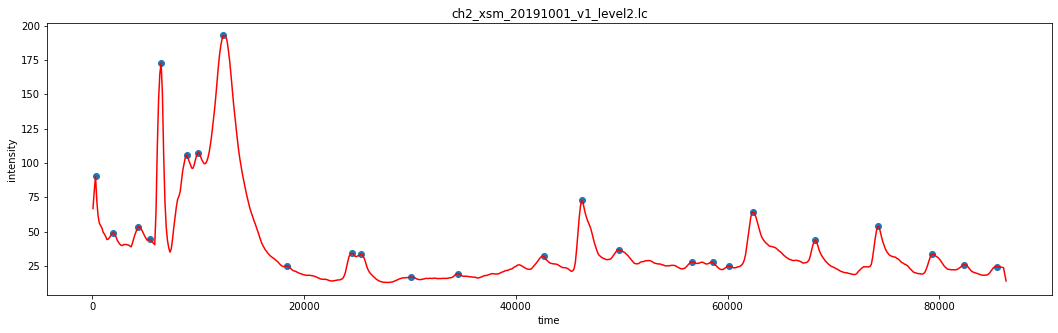

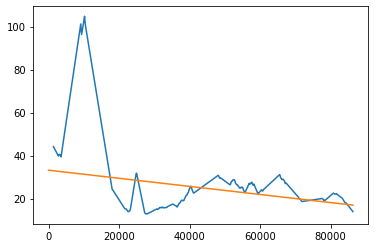

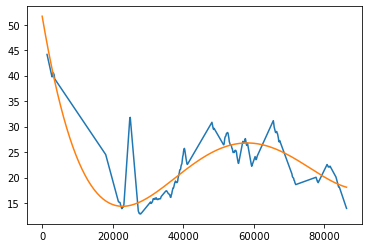

2.988526483609506
[-7.35418167e-01  1.96599644e+03  8.52713005e-02  2.04345602e-02
  1.15194073e+00]


C:\Users\ashwi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


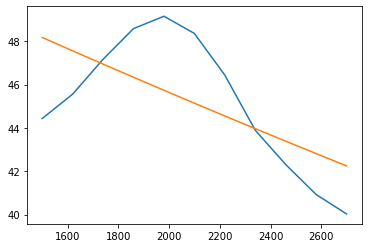

50.272792438207034
[3.48331491e+00 1.23626726e+04 1.66437908e+03 1.20059399e-02
 1.14493628e+00]


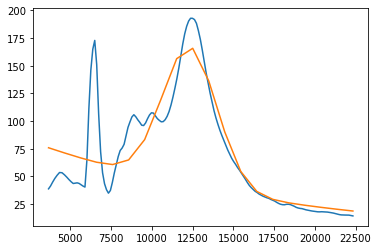

50.12219393592705
[1.27188924e+00 6.27076832e+03 2.30496253e+02 6.13172659e-03
 2.27174963e-01]


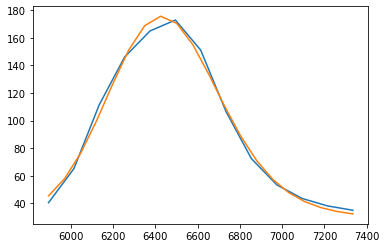

50.03781963690204
[5.61182360e+00 1.25044176e+04 1.28342957e+03 1.50277058e-02
 2.31430615e+00]


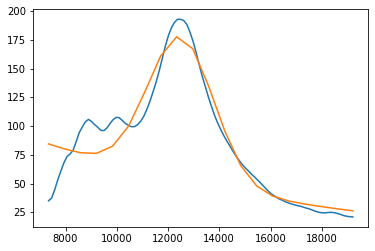

34.93606885797829
[1.24884600e+00 1.23213291e+04 7.23299967e+02 7.24659429e-03
 1.07066625e+00]


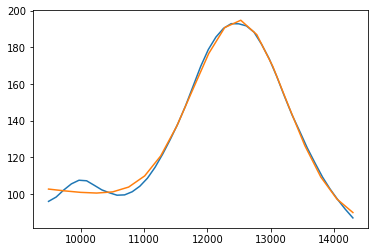

34.185334563950185
[7.70452019e-01 1.22425199e+04 7.47231787e+02 5.00065111e-03
 6.02047978e-01]


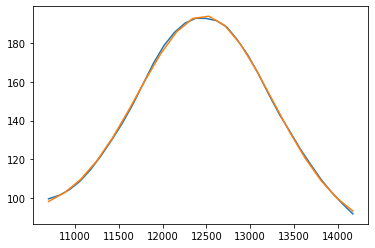

7.369706588329061
[4.29761822e-02 2.41361881e+04 7.86639871e+02 9.62198780e-04
 6.98349152e-03]


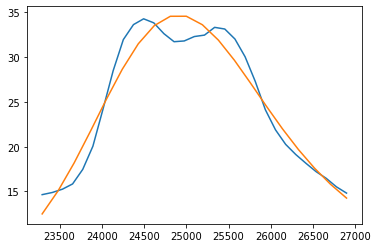

2.7429288396089784
[2.08401281e-02 4.18166351e+04 3.44700586e+02 8.89273106e-04
 2.42656204e-02]


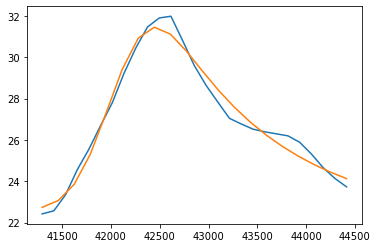

11.919447828990407
[1.52030793e+02 4.61158406e+04 2.53067612e+00 9.14934162e-03
 6.42800461e+00]


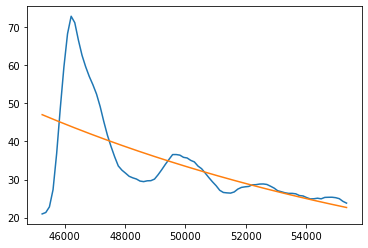

2.4214765475129165


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: invalid value encountered in add
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[6.69068865e+00 4.96927600e+04 5.04525860e+00 9.02745692e-04
 3.80006436e-02]


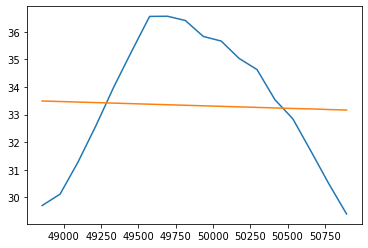

10.844131426917702


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: invalid value encountered in add
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[1.66359529e+00 6.23243880e+04 3.21009740e+01 3.70761553e-03
 5.07578413e-01]


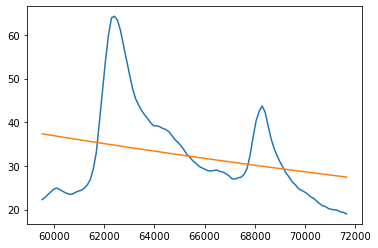

10.549389641450022


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[4.96429463e+01 6.23536796e+04 1.20364967e+01 7.31339372e-03
 6.48128864e+00]


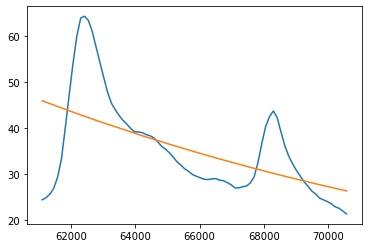

5.6806652687628665


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: invalid value encountered in add
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt
C:\Users\ashwi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 5.03338910e+00  6.82971983e+04 -1.87062855e+00  7.12566338e-03
  6.42220309e+00]


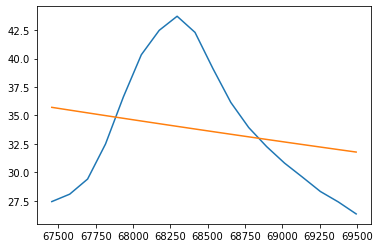

7.547658648072739


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: invalid value encountered in add
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[2.51924081e+00 7.40853976e+04 2.81067239e+01 4.09923419e-03
 7.97724991e-01]


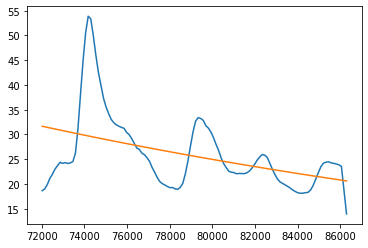

4.217778960285906


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[3.49031185e-02 7.86018181e+04 3.29417721e+02 1.02337728e-03
 3.39573111e-02]


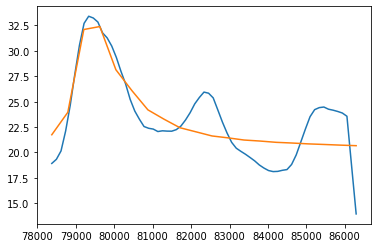

3.0285607753857637


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[ 1.14849920e+01  8.53892697e+04  4.79246003e+00 -2.84088390e-05
  5.89690099e-05]


C:\Users\ashwi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


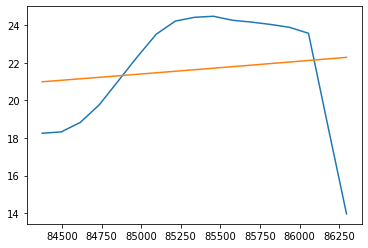

mean 19.29081066461133
std 7.465648605683834
median 17.885498312314354
max 85.04723176956178
increment 67.16173345724742


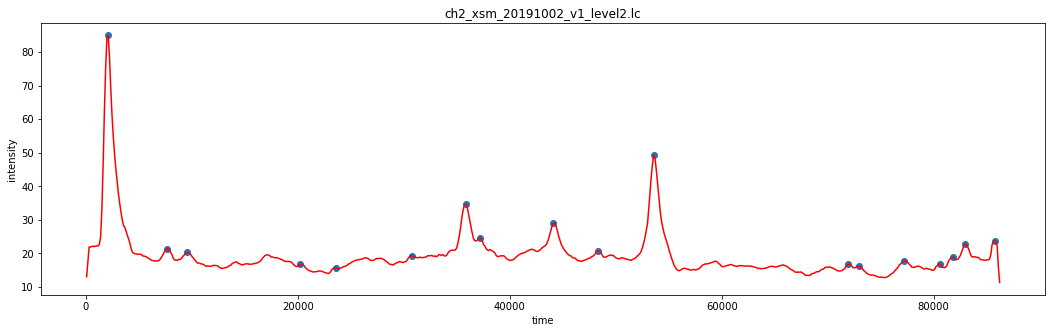

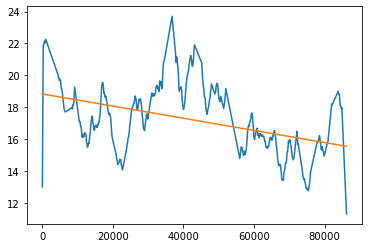

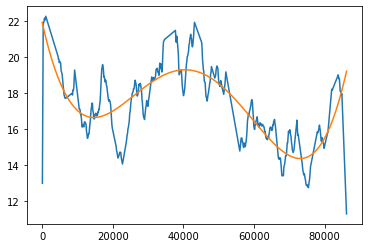

20.557660211332987
[9.88239082e+01 2.09670860e+03 7.08197700e+00 2.91407947e-02
 1.75027466e+00]


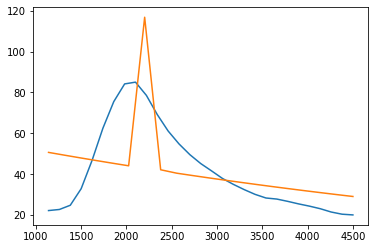

1.2666581922594513
[1.47373801e-02 7.44097003e+03 1.57810546e+02 3.18705345e-03
 6.84666710e-02]


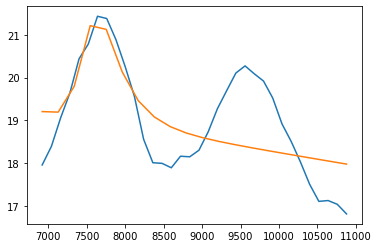

4.743329896719309
[7.42354507e-02 5.28344796e+04 3.24942273e+02 1.03459686e-03
 2.46795175e-02]


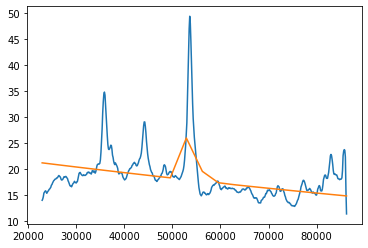

4.120328764447557
[3.75476282e-02 3.51845593e+04 3.08692963e+02 9.70035921e-04
 2.19962672e-02]


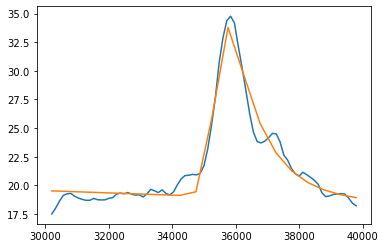

4.417771013114907
[5.08452463e-02 3.52940386e+04 2.68973614e+02 1.62429067e-03
 4.72800900e-02]


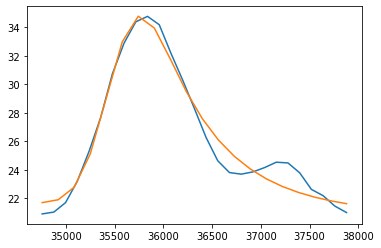

2.590566316308111
[4.04768658e-01 4.41221785e+04 9.19260826e+00 1.78220573e-03
 6.78339785e-02]


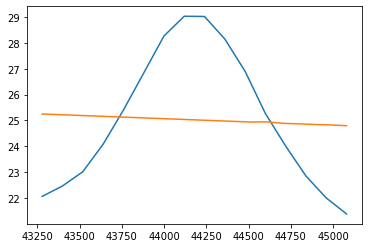

9.69689451534247


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[1.89316390e-01 5.30195942e+04 3.83790901e+02 2.57392704e-03
 1.10906006e-01]


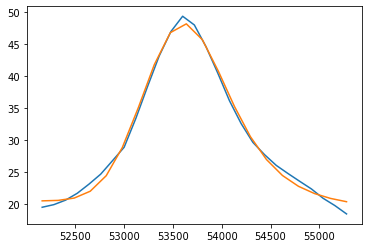

0.9168958966280756


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: invalid value encountered in add
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[5.71688930e-03 7.62830142e+04 3.82001916e+02 4.94253770e-04
 8.50830227e-03]


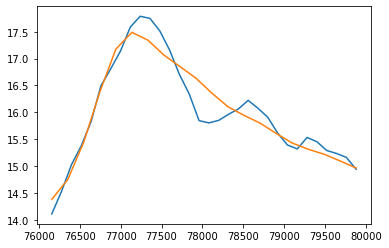

2.2772773500549195


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


[ 2.36931672e+00  8.57585000e+04  1.00000000e+01 -3.55014908e-05
  3.62668701e-05]


C:\Users\ashwi\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


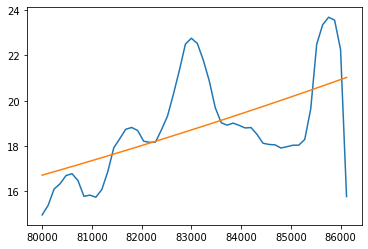

1.6457248254949717


C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:5: RuntimeWarning: overflow encountered in exp
  return  np.exp(-d*(x))
C:\Users\ashwi\AppData\Local\Temp\ipykernel_36984\1689599110.py:14: RuntimeWarning: overflow encountered in multiply
  sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

In [15]:
%matplotlib inline



def biquad(x,a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

for i in range(1,10):
    s = 'ch2_xsm_2019100' + str(i) + '_v1_level2.lc'
    
    dat = prepare_data(s)
    fl_marks, time, intensity = display_data(dat)#preliminary flare_marks are returned
    data_len = len(time)
    #fl_marks_broken = split_flare_marks(n,fl_marks,time[-1])
    #print(fl_marks_broken)

    i_new,t_new = remove_flares(fl_marks, time, intensity) #flareless backround returned
    
                #added initial and final values incase the fit gets drastically wrong - required for some binning values on some days
    
    #i_new.insert(0,intensity[0])
    #t_new.insert(0,time[0])
    #i_new = shrink_std(i_new)
    popt, pcov = curve_fit(line, t_new, i_new) #fit linear background

    m = popt[0]
    c = popt[1]
    plt.plot(t_new, i_new)
    arr = np.linspace(0,time[-1],200)
    y1 = []
    for i in arr:
        y1.append(line(i,m,c))
    plt.plot(arr,y1)
    plt.show()
    
    t_new, i_new = remove_outliers(t_new, i_new, m, c)#remove outliers
    plt.plot(t_new, i_new)
    
    #now we will break the data into parts and fit lines to each part
   # mark = len()
    
    popt, pcov = curve_fit(biquad, t_new, i_new)

    a = popt[0]
    b = popt[1]
    c = popt[2]
    d = popt[3]
    e = popt[4]
    arr = np.linspace(0,time[-1],200)
    y1 = []
    for i in arr:
        y1.append(biquad(i,a,b,c,d,e))
    plt.plot(arr,y1)
    plt.show()

    flare_starts = np.zeros(len(fl_marks))
    for i in range(len(fl_marks)):
        flare_starts[i] = fl_marks[i][0]

    #print(flare_starts)
    std_bg = np.std(i_new)

    flares_t = []
    flares_i = []
    for i in range(0,len(time)):
        if time[i] in flare_starts:
            l_t = []
            l_i = []
            #start = time[i]
            started = True
            for j in range(len(time)-i):
                l_t.append(time[i+j])
                l_i.append(intensity[i+j])
                if intensity[i+j] -  intensity[i] < biquad(time[i+j],a,b,c,d,e) - biquad(time[i],a,b,c,d,e):
                    started = False
                    if len(l_t) > 10 and max(l_i) - min(l_i) > std_bg :
                        flares_t.append(l_t)
                        flares_i.append(l_i)
                    break
            if started:
                started = False
                if len(l_t) > 10 and max(l_i) - min(l_i) > std_bg :
                    flares_t.append(l_t)
                    flares_i.append(l_i)
    
    
    for i in range(len(flares_t)):
        print(np.std(flares_i[i]))
        popt,pcov = curve_fit(convolution_flare, flares_t[i], flares_i[i],(max(flares_i[i])/10, flares_t[i][np.argmax(np.array(flares_i[i]))],10,0.01,np.mean(i_new)/10))
        a = popt[0]
        b = popt[1]
        c = popt[2]
        d = popt[3]
        e = popt[4]
        print(popt)
        #d = popt[3]
        #print(pcov)
        plt.plot(flares_t[i], flares_i[i])
        
        arr = np.linspace(flares_t[i][0],flares_t[i][-1],20)
        y1 = []
        for i in arr:
            y1.append(convolution_flare(i,a,b,c,d,e))
        plt.plot(arr,y1)
        plt.show()
    #print(i_new)

In [14]:
def gaussian(x,a,b,c,e):
    return a * np.exp(-((x-b)**2)/(2*c**2)) + e

def exponential(x,d):
    return  np.exp(-d*(x))


def convolution_flare(x, a,b,c,d,e):
    n = 100
    dt = x/n
    t = 0
    sum = 0
    for i in range(n):
        sum += gaussian(t,a,b,c,e)*exponential(x-t,d)*dt
        t += dt
    return sum




